In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import sys
from textwrap import wrap


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [3]:
sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
import cWGAN

In [4]:
save_dir = '../models/cWGAN/Run_2021-03-21_0/'
assert(os.path.isdir(save_dir))

In [5]:
delphesJets = np.loadtxt('../test.txt', skiprows=2)

In [6]:
print(delphesJets[0])

[41.4024   -1.27316  -0.891338 80.6118   42.3483   -1.37507  -0.827343
 36.3716   -1.24909  -0.87713 ]


In [7]:
data = np.loadtxt('../data/processed/newPartonMatchedJetsNoRecoPtCut.txt', skiprows=2)

In [22]:
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)

partonPtMin = np.min(data[:, 0], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
pfMean = np.mean(data[:, 5:7], axis=0)
pfStd = np.std(data[:, 5:7], axis=0)
pfPtMin = np.min(data[:, 4], axis=0)
pfEMin = np.min(data[:, 7], axis=0)

normalized_data = np.zeros((len(delphesJets), 4))
normalized_old_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))

np.log10(delphesJets[:, 0], out=normalized_data[:, 0])
np.log10(delphesJets[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 0], out=normalized_old_data[:, 0])
np.log10(data[:, 3], out=normalized_old_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])


normalized_data[:, 1:3] = delphesJets[:, 1:3]
normalized_old_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_old_data, axis=0)
normalized_std = np.std(normalized_old_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

normalized_data = (normalized_data - normalized_mean) / normalized_std

In [14]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [15]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_560000')

In [23]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 58 s, sys: 7.11 s, total: 1min 5s
Wall time: 2.5 s


In [24]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
predict[:, 3] = 10**predict[:, 3]

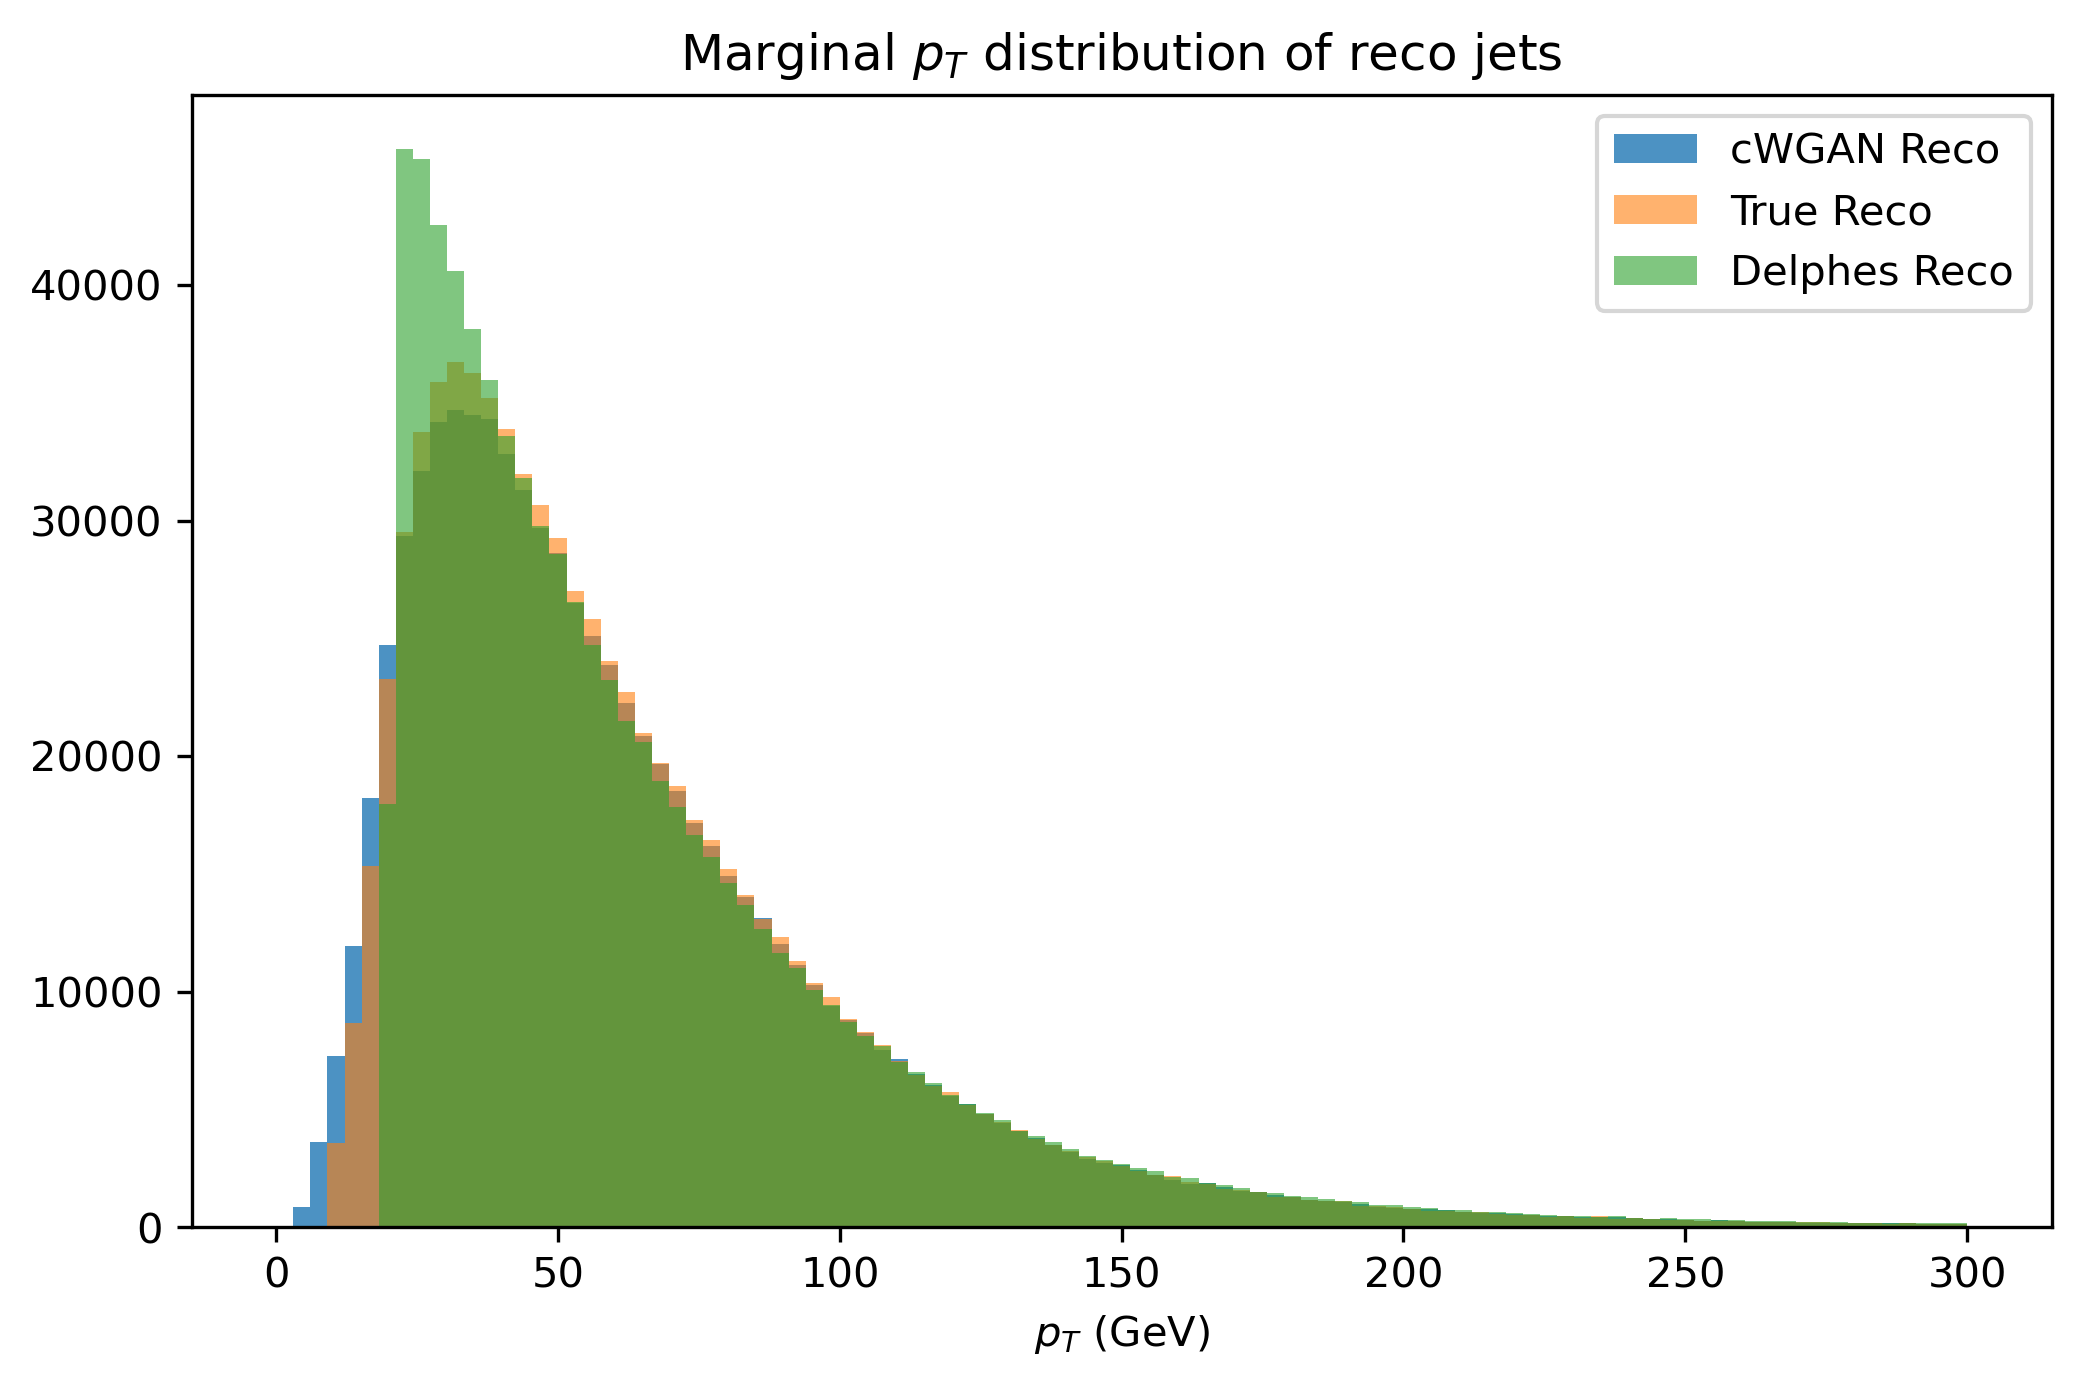

In [27]:
bins = np.linspace(0, 300, 100)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
ax.hist(predict[:, 0], bins=bins, label="cWGAN Reco", alpha=0.8)
ax.hist(delphesJets[:, 7], bins=bins, label="True Reco", alpha=0.6)
ax.hist(delphesJets[:, 4], bins=bins, label="Delphes Reco", alpha=0.6)
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_title(r"Marginal $p_T$ distribution of reco jets")
ax.legend()
plt.show()

center=50
center=75
center=100
center=125
center=150
center=200
center=250
center=300
center=600


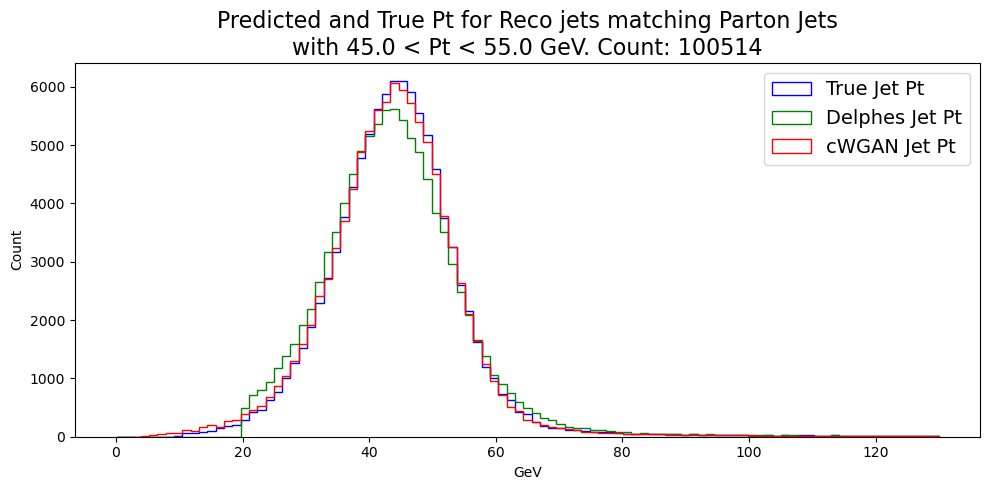

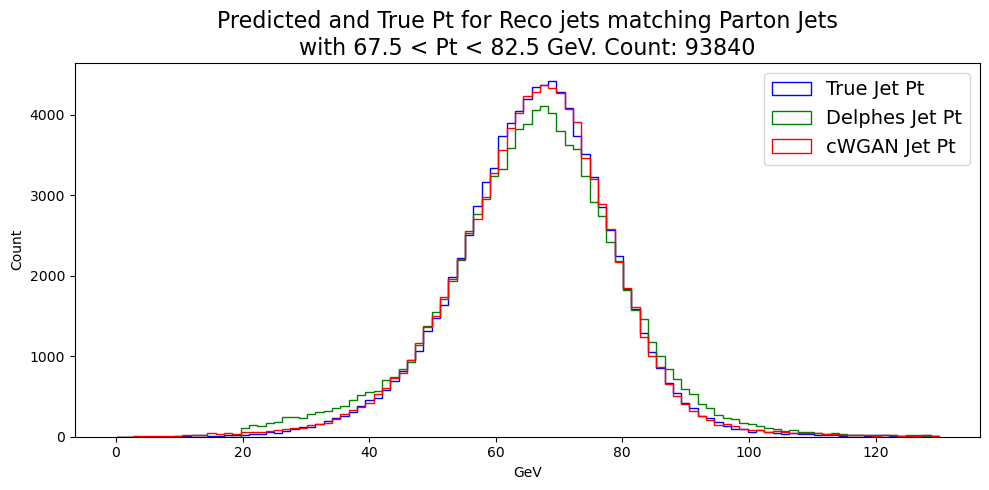

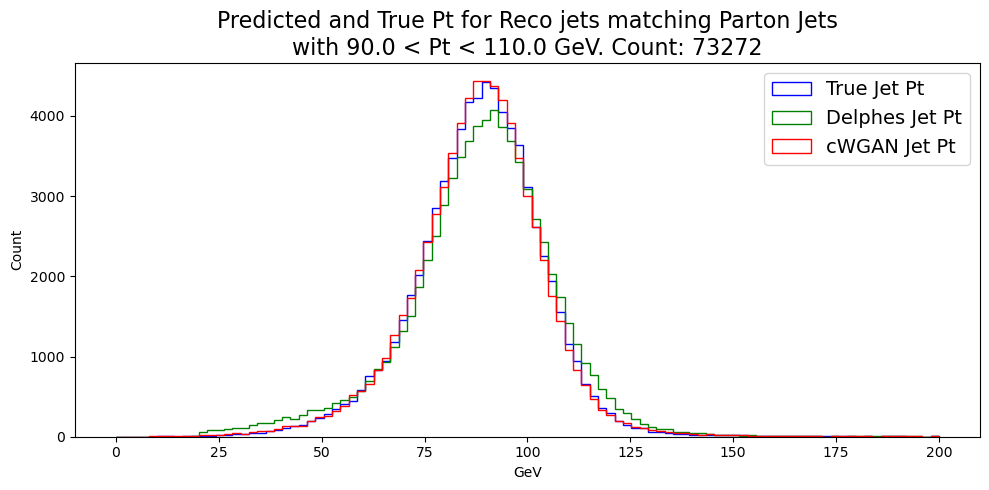

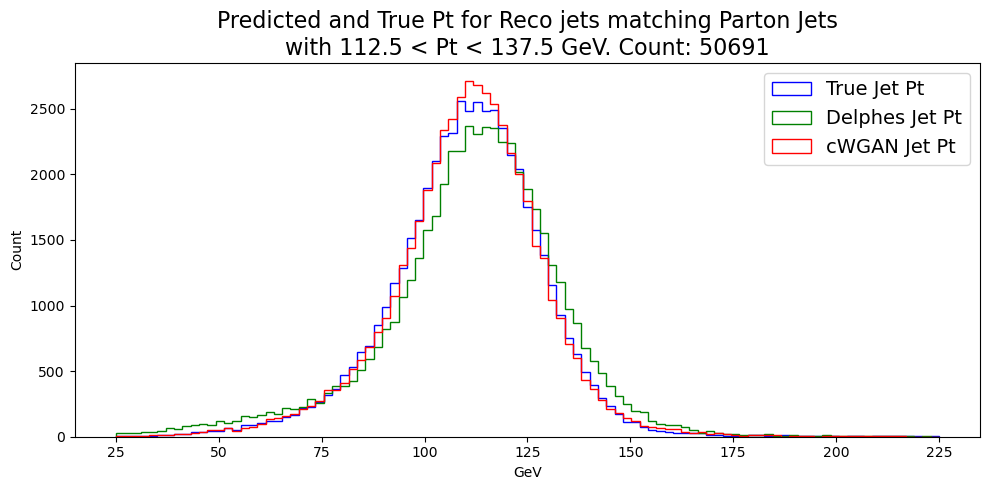

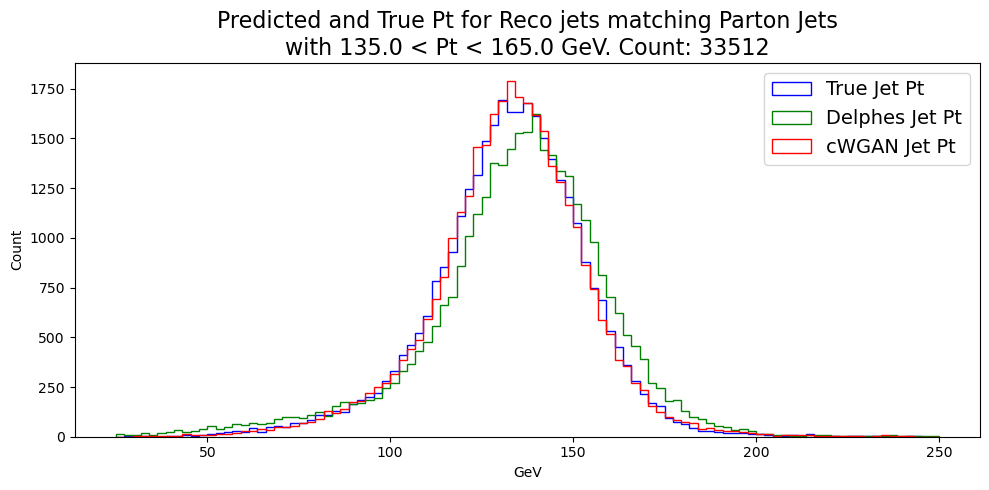

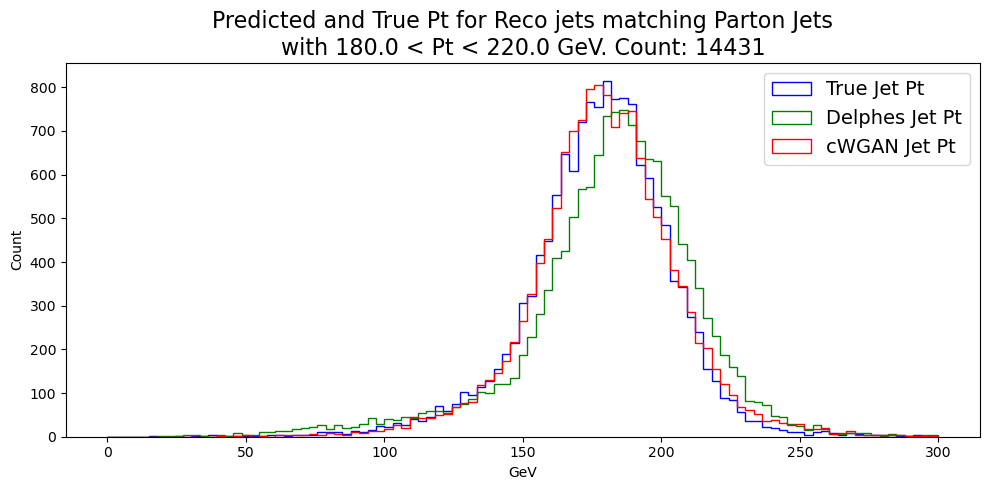

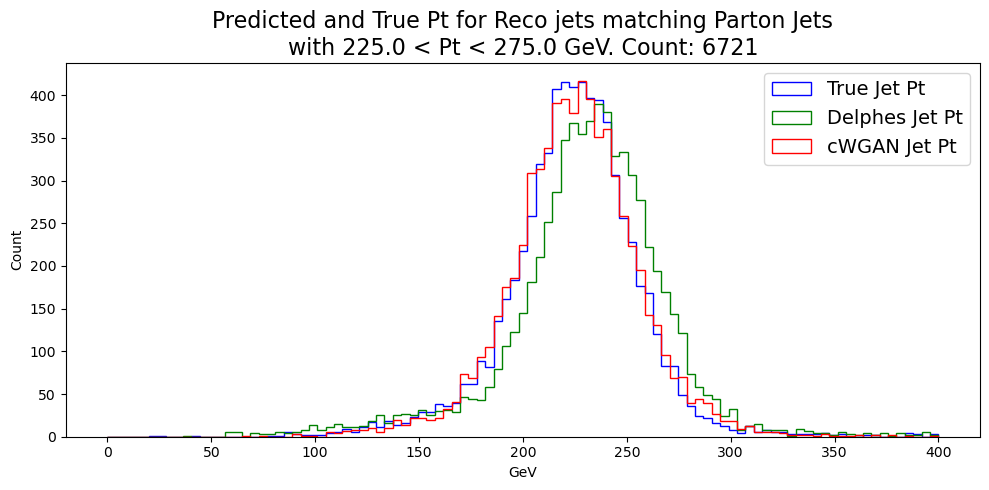

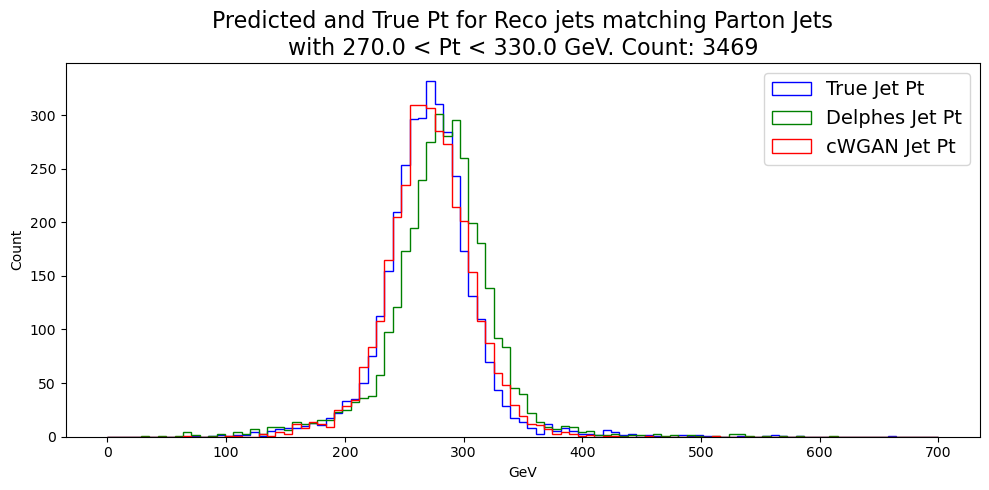

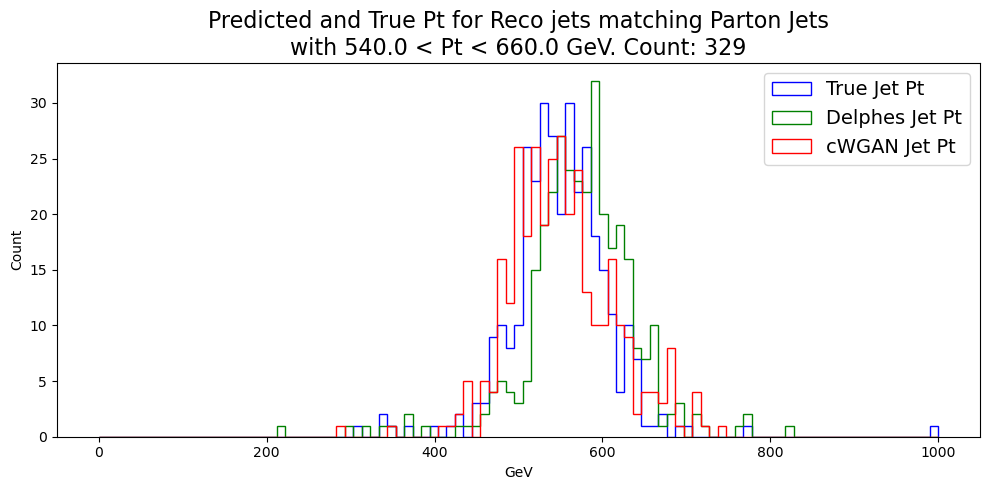

In [32]:
range_highs = [130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
for center in [50, 75, 100, 125, 150, 200, 250, 300, 600]:  
    print("center={}".format(center))
    delphesPt = []
    realPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(delphesJets)):
        if (delphesJets[i, 0] > low and delphesJets[i, 0] < high):
            delphesPt.append(delphesJets[i, 4])
            realPt.append(delphesJets[i, 7])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(realPt, bins=bins, label='True Jet Pt', alpha=1, ec="b", histtype='step')
    ax.hist(delphesPt, bins=bins, label='Delphes Jet Pt', alpha=1, ec="g", histtype='step')
    ax.hist(predPt, bins=bins, label='cWGAN Jet Pt', alpha=1, ec="r", histtype='step')

    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(delphesPt)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #plt.show()
    fig.savefig("../data/plots/PtDistDelphes{}.png".format(j), facecolor="white", transparent="True")
    j+=1